In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('application_train.csv')

# Show shape and preview
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (17474, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Count and percentage of missing values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

# Combine into a single DataFrame
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage (%)': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

print("Columns with missing values:")
missing_df


Columns with missing values:


,Missing Values,Percentage (%)
COMMONAREA_AVG,12242,70.058372
COMMONAREA_MEDI,12242,70.058372
COMMONAREA_MODE,12242,70.058372
NONLIVINGAPARTMENTS_AVG,12135,69.446034
NONLIVINGAPARTMENTS_MEDI,12135,69.446034
...,...,...
FLAG_DOCUMENT_16,1,0.005723
FLAG_DOCUMENT_15,1,0.005723
FLAG_DOCUMENT_14,1,0.005723
FLAG_DOCUMENT_20,1,0.005723


In [5]:
# Basic checks on key numeric columns
print("Negative incomes:", (df['AMT_INCOME_TOTAL'] < 0).sum())
print("Negative credit amount:", (df['AMT_CREDIT'] < 0).sum())
print("Negative annuity amount:", (df['AMT_ANNUITY'] < 0).sum())

# Check for unrealistic employment duration
unrealistic_employment = df[df['DAYS_EMPLOYED'] > 100000]
print("Unrealistic DAYS_EMPLOYED values:", len(unrealistic_employment))

# Check for extreme age (DAYS_BIRTH is in negative days)
print("Minimum age in years:", (-df['DAYS_BIRTH'].max()) // 365)
print("Maximum age in years:", (-df['DAYS_BIRTH'].min()) // 365)

# View records with multiple quality issues (optional preview)
df_quality_issues = df[
    (df['AMT_INCOME_TOTAL'] < 0) |
    (df['AMT_CREDIT'] < 0) |
    (df['AMT_ANNUITY'] < 0) |
    (df['DAYS_EMPLOYED'] > 100000)
]
df_quality_issues[['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED']]


Negative incomes: 0
Negative credit amount: 0
Negative annuity amount: 0
Unrealistic DAYS_EMPLOYED values: 3127
Minimum age in years: 21
Maximum age in years: 68


,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED
8,100011,112500.000,1019610.0,33826.5,365243
11,100015,38419.155,148365.0,10678.5,365243
23,100027,83250.000,239850.0,23850.0,365243
38,100045,99000.000,247275.0,17338.5,365243
43,100050,108000.000,746280.0,42970.5,365243
...,...,...,...,...,...
17446,120348,45000.000,121500.0,11371.5,365243
17455,120357,56250.000,182286.0,17127.0,365243
17460,120362,67500.000,231813.0,10341.0,365243
17464,120366,207000.000,504000.0,21483.0,365243


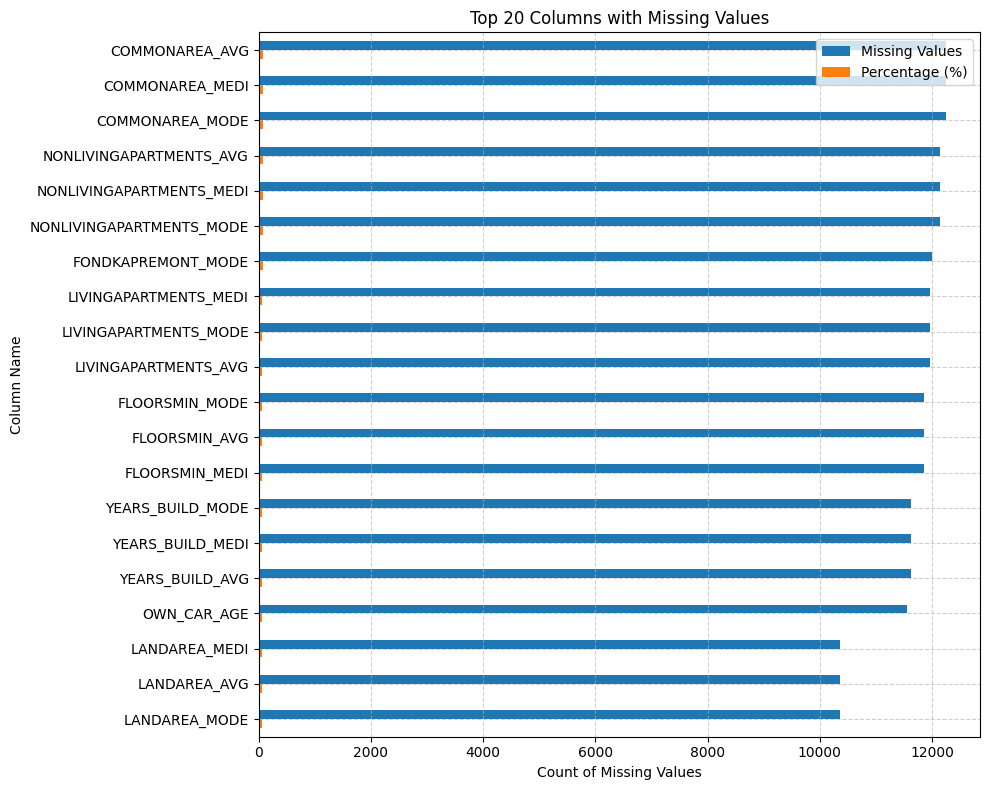

In [7]:
import matplotlib.pyplot as plt

# Plot top 20 columns with most missing data
missing_df.head(20).plot(kind='barh', figsize=(10, 8))
plt.title('Top 20 Columns with Missing Values')
plt.xlabel('Count of Missing Values')
plt.ylabel('Column Name')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [8]:
# Define logical flags for known issues
df['flag_negative_income'] = df['AMT_INCOME_TOTAL'] < 0
df['flag_negative_credit'] = df['AMT_CREDIT'] < 0
df['flag_negative_annuity'] = df['AMT_ANNUITY'] < 0
df['flag_unrealistic_employment'] = df['DAYS_EMPLOYED'] > 100000

# Count number of issues per row
df['issue_count'] = (
    df['flag_negative_income'].astype(int) +
    df['flag_negative_credit'].astype(int) +
    df['flag_negative_annuity'].astype(int) +
    df['flag_unrealistic_employment'].astype(int)
)

# View summary
issue_summary = df['issue_count'].value_counts().sort_index()
print("Number of records by issue count:")
print(issue_summary)

# Preview flagged records
df_flagged = df[df['issue_count'] > 0]
df_flagged[['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'issue_count']].head()


Number of records by issue count:
issue_count
0    14347
1     3127
Name: count, dtype: int64


,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,issue_count
8,100011,112500.000,1019610.0,33826.5,365243,1
11,100015,38419.155,148365.0,10678.5,365243,1
23,100027,83250.000,239850.0,23850.0,365243,1
38,100045,99000.000,247275.0,17338.5,365243,1
43,100050,108000.000,746280.0,42970.5,365243,1


In [9]:
# Export only the rows with one or more data quality issues
df_flagged.to_csv('flagged_mortgage_records.csv', index=False)
print("Flagged records saved as 'flagged_mortgage_records.csv'")



Flagged records saved as 'flagged_mortgage_records.csv'
